# library

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# import data

In [2]:
lien_csv = "https://raw.githubusercontent.com/pierrebeguin/Master_2_defi_2/main/data_defi_2.csv"
response = requests.get(lien_csv)
data = pd.read_csv(StringIO(response.text), sep=";")

# supprimer la 1er ligne
data.columns = data.iloc[0]
data = data.iloc[1:].reset_index(drop=True)

# renommer les colonnes
data = data.rename(columns={'Libellé.Prescription': 'medicament', 'Avis.Pharmaceutique' : 'avis'})

# Suppression des lignes où la colonne 'avis' est vide
data = data.dropna(subset=['avis'])

# Créer les colonnes IP_1 et IP_2
data['PLT'] = pd.to_numeric(data['PLT'], errors='coerce')
data['IP_1'] = np.where(data['PLT'].isin([4.1, 4.2, 5.1, 5.2, 5.3, 6.3, 6.4]), 1, 0)
data['IP_2'] = np.floor(data['PLT']).astype(int)

display(data.head())

,medicament,avis,PLT,IP_1,IP_2
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3,1,5
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1,1,4
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1,1,4
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1,1,4
4,VANCOMYCINE 500 mg 1x/j,posologie infraT veuillez réévaluer la posolog...,3.1,0,3


In [3]:
#data.groupby('IP_2').size()
#data.shape

# Préparation_1

In [4]:
# définir X et y
X = data['avis']
y = data['IP_1']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

# Paramètres de tokenisation
max_words = 10000
max_len = 100

# Initialiser le tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertir les textes en séquences de tokens
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Ajouter du padding pour uniformiser la longueur des séquences
X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

# Modèle_1

In [5]:
# Création du modèle de réseau de neurones
model_1 = Sequential([
    Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8061 - loss: 0.5004 - val_accuracy: 0.8134 - val_loss: 0.3864
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8231 - loss: 0.3739 - val_accuracy: 0.8792 - val_loss: 0.2817
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8744 - loss: 0.2919 - val_accuracy: 0.8952 - val_loss: 0.2582
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8983 - loss: 0.2493 - val_accuracy: 0.9028 - val_loss: 0.2277
Epoch 5/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9099 - loss: 0.2202 - val_accuracy: 0.9110 - val_loss: 0.2168
Epoch 6/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9183 - loss: 0.2046 - val_accuracy: 0.9147 - val_loss: 0.2081
Epoch 7/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9222 - loss: 0.1922 - val_accuracy: 0.9209 - val_loss: 0.2079
Epoch 8/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9291 - loss: 0.1787 - val_accuracy: 0.9192 - val_

# Evaluation_1

In [6]:
# Prédictions sur les données de test
y_pred_proba = model_1.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")
print("\nMatrice de confusion :\n", conf_matrix)
print("\nClassification Report :\n", class_report)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy : 0.91
Precision: 0.75
Recall   : 0.84
F1 Score : 0.79

Matrice de confusion :
 [[3463  260]
 [ 143  763]]

Classification Report :
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      3723
           1       0.75      0.84      0.79       906

    accuracy                           0.91      4629
   macro avg       0.85      0.89      0.87      4629
weighted avg       0.92      0.91      0.91      4629



145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


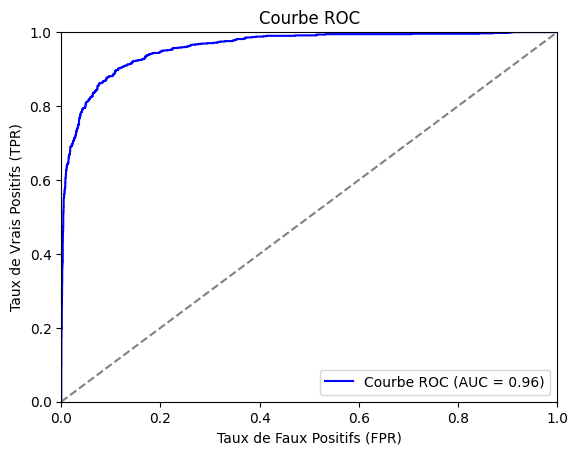

In [7]:
y_pred_proba = model_1.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Préparation_2

In [8]:
# définir X et y
X = data['avis']
y = data['IP_2']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

# Paramètres de tokenisation
max_words = 10000
max_len = 100

# Initialiser le tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertir les textes en séquences de tokens
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Ajouter du padding pour uniformiser la longueur des séquences
X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

# Modèle_2

In [9]:
# Création du modèle de réseau de neurones
model_2 = Sequential()
model_2.add(Embedding(input_dim=max_words, output_dim=16, input_length=max_len))
model_2.add(LSTM(64, return_sequences=True))
model_2.add(GlobalAveragePooling1D())
model_2.add(Dense(12, activation='softmax'))

# Compilation du modèle
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
model_2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


579/579 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.4987 - loss: 1.6245 - val_accuracy: 0.5740 - val_loss: 1.2368
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6379 - loss: 1.0857 - val_accuracy: 0.6528 - val_loss: 1.0775
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.6873 - loss: 0.9554 - val_accuracy: 0.6719 - val_loss: 1.0201
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7325 - loss: 0.8058 - val_accuracy: 0.7256 - val_loss: 0.8400
Epoch 5/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.7963 - loss: 0.6291 - val_accuracy: 0.7438 - val_loss: 0.7865
Epoch 6/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.8325 - loss: 0.5212 - val_accuracy: 0.7572 - val_loss: 0.7763
Epoch 7/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8499 - loss: 0.4767 - val_accuracy: 0.7531 - val_loss: 0.7734
Epoch 8/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.8683 - loss: 0.4229 - val_accurac

# Evaluation_2

In [10]:
# Prédire sur l'ensemble de test
y_pred = model_2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Évaluation détaillée
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.88      0.89      2253
           2       0.64      0.71      0.67       151
           3       0.33      0.23      0.27       194
           4       0.70      0.78      0.74       613
           5       0.53      0.59      0.56       166
           6       0.91      0.79      0.84       193
           7       0.00      0.00      0.00         2
           8       0.73      0.77      0.75       589
           9       0.00      0.00      0.00         4
          10       0.62      0.51      0.56       148
          11       0.54      0.58      0.56       316

    accuracy                           0.77      4629
   macro avg       0.54      0.53      0.53      4629
weighted avg       0.77      0.77      0.77      4629

Confusion Matrix:
[[1979   28   46   52   13    5    0   71    0    9   50]
 [  26  107    0    1    7    0    0    3    0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


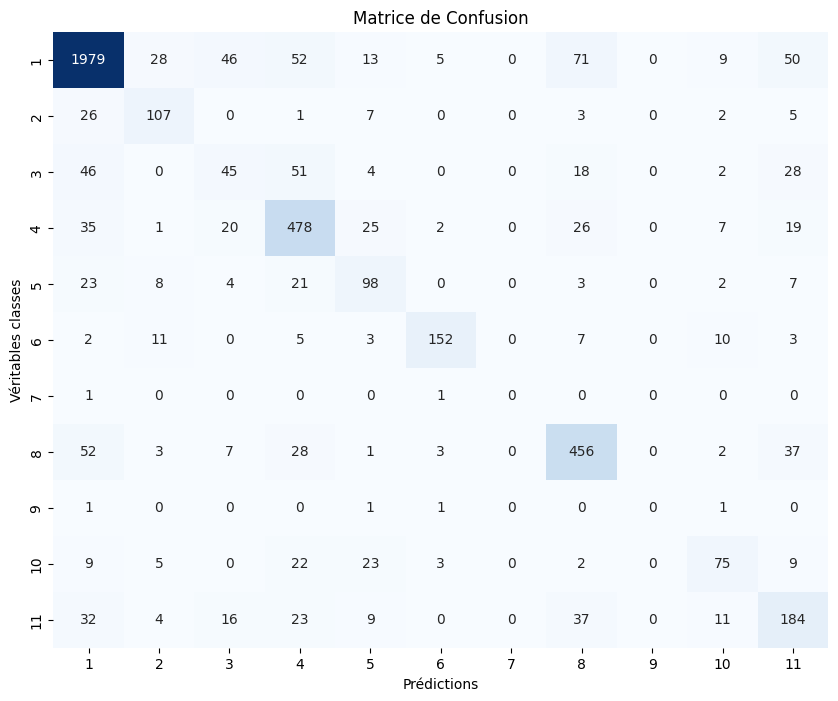

In [11]:
# Matrice de Confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(1, 12), yticklabels=range(1, 12))
plt.xlabel("Prédictions")
plt.ylabel("Véritables classes")
plt.title("Matrice de Confusion")
plt.show()

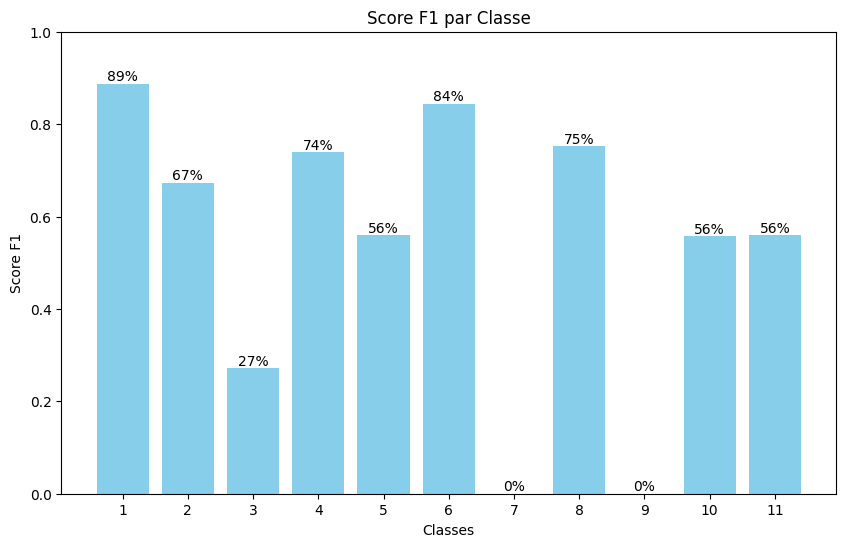

In [14]:
f1_scores = f1_score(y_test, y_pred_classes, average=None)
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, 12), f1_scores, color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Score F1")
plt.title("Score F1 par Classe")
plt.xticks(range(1, 12))
plt.ylim(0, 1)
# Ajouter les pourcentages au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.0%}", ha='center', va='bottom')
plt.show()